# Figuring out ONNX inference pipeline

Looked into this before briefly, doing a more in-depth exploration to ensure that the pieces fit together correctly.

In [2]:
from PIL import Image

## Generating the model

In [2]:
from art import Net, create_input
import numpy as np
import torch
import torch.onnx
import onnx
import onnxruntime

In [3]:
# Keep track of all parameters here
latent_len = 3
XDIM = 160
YDIM = 90
input_config = {
    "img_width": XDIM,
    "img_height": YDIM,
    "xs_start": -1,
    "xs_stop": 0,
    "ys_start": -1,
    "ys_stop": 0,
}

In [4]:
# Init net
net = Net(num_hidden_layers=2, num_neurons=64, latent_len=latent_len)

In [5]:
# Create input examples for torch tracing for compilation to ONNX
net_input = torch.FloatTensor(create_input(**input_config))
latent_vec = np.random.normal(size=(latent_len,))
latent_vec = np.expand_dims(latent_vec, axis=0)
latent_vec = np.repeat(latent_vec, repeats=net_input.shape[0], axis=0)
latent_vec = torch.FloatTensor(latent_vec)

In [7]:
torch.onnx.export(
    net,
    (net_input, latent_vec),
    "../assets/test-onnx-model.onnx",
    export_params=True,
    opset_version=10,
    do_constant_folding=True,
    input_names=["spatial-input", "latent-vec"],
    output_names=["output-rgb"],
)

## Inference

Code in this section should be able to run standalone w/o torch.

In [9]:
import onnx
import onnxruntime
import numpy as np
from art import create_input

In [4]:
# Verify ONNX is valid
onnx_model = onnx.load("../assets/test-onnx-model.onnx",)
onnx.checker.check_model(onnx_model)

In [5]:
# Verify that the input used is valid
ort_session = onnxruntime.InferenceSession("../assets/test-onnx-model.onnx",)

In [6]:
# Keep track of all parameters here
latent_len = 3
XDIM = 160
YDIM = 90
input_config = {
    "img_width": XDIM,
    "img_height": YDIM,
    "xs_start": -1,
    "xs_stop": 0,
    "ys_start": -1,
    "ys_stop": 0,
}

In [10]:
net_input = create_input(**input_config)

In [11]:
latent_vec = np.random.standard_normal(size=(latent_len,))
latent_vec = np.expand_dims(latent_vec, axis=0)
latent_vec = np.repeat(latent_vec, repeats=net_input.shape[0], axis=0)

In [14]:
net_input.shape, latent_vec.shape

((14400, 3), (14400, 3))

In [12]:
ort_inputs = {
    "spatial-input": net_input.astype(np.float32),
    "latent-vec": latent_vec.astype(np.float32),
}

In [13]:
ort_outs = ort_session.run(["output-rgb"], ort_inputs)
out = ort_outs[0]

In [16]:
# Reshape into (y, x, 3) for plotting in PIL
out = out.reshape(
    input_config["img_height"], input_config["img_width"], -1
)

In [17]:
# Re-format to color output
# Scale to range 0 to 255, and set type to int
out = (out * 255).astype(np.uint8)

In [18]:
out.shape

(90, 160, 3)

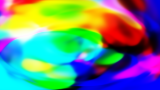

In [20]:
Image.fromarray(out)

Need to replicate a bit of logic already wrapped in `generate_one_art`, but otherwise just minor changes. More refactoring needed.